<a href="https://colab.research.google.com/github/VGGatGitHub/AnswerFlow/blob/master/chatbot_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets?search=nq-train

V2: added comads to look at the structure of the train.json file and to assess the %s.

V3: changing the code to do tarining for long_answesrs or short_answers using training_for_long_answer switch.

V4: reading in json file produced from jsonl using jsonl2json.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
import os
print(os.getcwd())

/content


In [0]:
#VGG define the foldre to inspect for files 
path='/content/drive/My Drive/Colab Notebooks/'

In [4]:
#make sure the file you what is in the correct directory
#some possible files are train.json or train200.json 

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Colab Notebooks/chatbot_v2 (1).ipynb
/content/drive/My Drive/Colab Notebooks/train.json
/content/drive/My Drive/Colab Notebooks/loding_files.ipynb
/content/drive/My Drive/Colab Notebooks/Copy of qa.ipynb
/content/drive/My Drive/Colab Notebooks/chatbot_v2.ipynb
/content/drive/My Drive/Colab Notebooks/simplified-nq-train.jsonl
/content/drive/My Drive/Colab Notebooks/chatbot_v3.ipynb
/content/drive/My Drive/Colab Notebooks/text_utils.py
/content/drive/My Drive/Colab Notebooks/jsonl2json.ipynb
/content/drive/My Drive/Colab Notebooks/chatbot_v6.ipynb
/content/drive/My Drive/Colab Notebooks/train200.json
/content/drive/My Drive/Colab Notebooks/train200L.json
/content/drive/My Drive/Colab Notebooks/Copy of jsonl2json.ipynb
/content/drive/My Drive/Colab Notebooks/__pycache__/text_utils.cpython-36.pyc


In [0]:
#VGG read in training data
#you may have to adjust the BATCH_SIZE acordingly 
filename='train200.json' #or train.json or train200L.json 


file_to_read=path+filename

In [0]:
# VGG
# you may need to get the file text_utils.py from 
# https://github.com/VGGatGitHub/natural-questions
#

sys.path.append(os.path.abspath(path))
from text_utils import *


In [0]:
#VGG The cell has been removed since now the data is analized in the jsonl2json.ipynb

In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)


TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import json

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w


In [0]:
#VGG make sure the file_to_read has been defined above! 

UNKNOWN = "<UNKNOWN>"
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset():
    source = []
    target = []
    context = []

    n_short_answers=0 #VGG
    n_long=0
    training_for_long_answer = False #True #False 
    
    with open(file_to_read) as json_file: #VGG
        data = json.load(json_file)

        for nq_doc in data:
            if filename == 'train200L.json':
              doc = simplify_nq_example(nq_doc) #VGG for jsonl formated file
            else:
              doc=nq_doc

            question_text = doc['question_text']
            document_text = doc['document_text'].split()
            long_answer_candidates = doc['long_answer_candidates']
            annotations = doc['annotations'][0]
            
            if annotations['long_answer']['start_token'] < annotations['long_answer']['end_token']:
                
                n_long+=1
                long_answer = " ".join(document_text[annotations['long_answer']['start_token']:
                                                     annotations['long_answer']['end_token']])
                                      
                if len(annotations['short_answers']) > 0:
                    start_token = annotations['short_answers'][0]['start_token']
                    end_token = annotations['short_answers'][0]['end_token']
                    short_answer = " ".join(document_text[start_token:end_token])
                    n_short_answers+=1 #VGG
                else:
                    short_answer = UNKNOWN
                
                #VGG V3
                if training_for_long_answer :
                    short_answer=long_answer #VGG V3 change - make the target to be the long answer instead of the short answer 
                    for posibilities in long_answer_candidates:
                        if posibilities["top_level"]:
                            start_token = posibilities['start_token']
                            end_token = posibilities['end_token']                    
                            posibility = " ".join(document_text[start_token:end_token])
                            context.append(preprocess_sentence(posibility))
                else:
                    context.append(preprocess_sentence(long_answer))
                
                #VGG context = [] #VGG it seems to work better!

                source.append(preprocess_sentence(question_text))
                target.append(preprocess_sentence(short_answer))
#VGG                
        print("Data set contains:", n_short_answers,"short answers out of",
              n_long,"possible long answers, rate is {:.0f}%".format(100*n_short_answers/n_long))    
    return target, source, context
 

In [11]:
def max_length(tensor):
    return max(len(t) for t in tensor)
    
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

def load_dataset():
    # creating cleaned input, output pairs
    targ_lang, inp_lang, context_lang = create_dataset()

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))
    
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights
    
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

# Try experimenting with the size of that dataset
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset()

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)    

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 1 #VGG
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)    
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ = tf.multiply(loss_, mask)
  return tf.reduce_mean(loss_)


#VGG uncommented for possible checkpoint saving later 

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)  

                                 
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss
  
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index.get(i, 0) for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    result ='<start> '#VGG 
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot
    


Data set contians: 70 short answers out of 101 possible long answers, rate is 69%


In [12]:
EPOCHS = 100

#VGG for epoch in range(EPOCHS):
epoch=-1
total_loss=1
total_loss_cut=0.01*steps_per_epoch

print("\nStarting training of at most {} epochs or until total loss is les than {:0.4f}".format(EPOCHS,total_loss_cut))
while (epoch < EPOCHS) and (total_loss > total_loss_cut):
  epoch+=1

  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch%8 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  '''
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
  '''   

  print('Epoch {} Total Loss {:.4f}'.format(epoch + 1, total_loss))
  print('Time taken for this epoch {:.4f} sec\n'.format(time.time() - start))


Starting training of at most 100 epochs or until total loss is les than 0.8000
Epoch 1 Batch 0 Loss 0.5445
Epoch 1 Batch 8 Loss 0.8582
Epoch 1 Batch 16 Loss 0.3186
Epoch 1 Batch 24 Loss 0.2060
Epoch 1 Batch 32 Loss 0.3134
Epoch 1 Batch 40 Loss 0.5052
Epoch 1 Batch 48 Loss 1.0866
Epoch 1 Batch 56 Loss 2.9200
Epoch 1 Batch 64 Loss 1.0876
Epoch 1 Batch 72 Loss 0.5014
Epoch 1 Total Loss 58.9683
Time taken for this epoch 52.3484 sec

Epoch 2 Batch 0 Loss 0.0608
Epoch 2 Batch 8 Loss 2.2327
Epoch 2 Batch 16 Loss 0.0154
Epoch 2 Batch 24 Loss 0.0762
Epoch 2 Batch 32 Loss 0.5553
Epoch 2 Batch 40 Loss 0.4938
Epoch 2 Batch 48 Loss 0.8827
Epoch 2 Batch 56 Loss 0.0780
Epoch 2 Batch 64 Loss 4.6570
Epoch 2 Batch 72 Loss 2.6371
Epoch 2 Total Loss 50.2365
Time taken for this epoch 21.9901 sec

Epoch 3 Batch 0 Loss 1.9752
Epoch 3 Batch 8 Loss 0.0411
Epoch 3 Batch 16 Loss 0.3643
Epoch 3 Batch 24 Loss 0.0679
Epoch 3 Batch 32 Loss 0.3481
Epoch 3 Batch 40 Loss 0.6428
Epoch 3 Batch 48 Loss 0.5898
Epoch 3 Bat

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def ask(sentence):
    result, sentence1, attention_plot = evaluate(sentence)
    print('\nQuestion: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    return result

def show_attention_plot(sentence):
  result, sentence1, attention_plot = evaluate(sentence)
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

def is_it_known(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    if result.split() != ['<start>', 'unknown', '<end>']: return True
    return False


In [14]:
ask('which is the most common use of opt-in e-mail marketing')    
ask('most common use of opt-in e-mail marketing')
ask('how did I meet your mother')
ask('who is your mother')


Question: which is the most common use of opt-in e-mail marketing
Predicted answer: <start> on the southern region of the land of texas , nebraska <end> 

Question: most common use of opt-in e-mail marketing
Predicted answer: <start> yokota air base , western tokyo <end> 

Question: how did I meet your mother
Predicted answer: <start> the supreme governor <end> 

Question: who is your mother
Predicted answer: <start> chris pine <end> 


'<start> chris pine <end> '

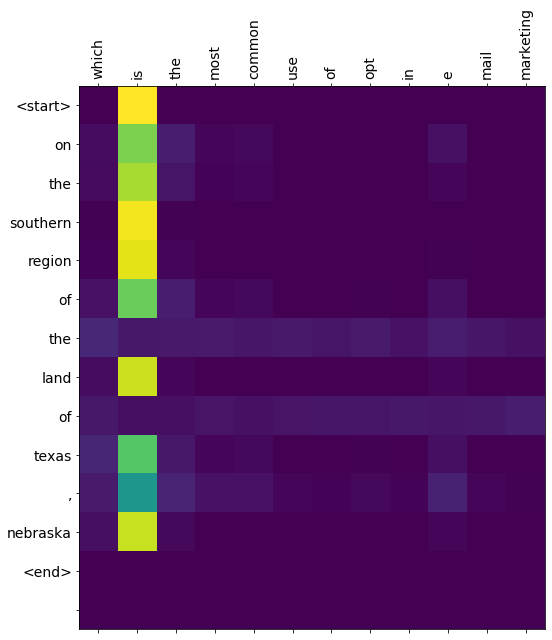

In [15]:
show_attention_plot("which is the most common use of opt in e mail marketing")

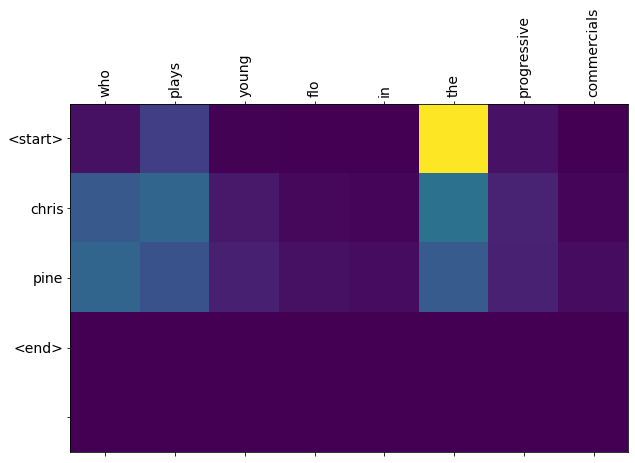

In [16]:
show_attention_plot("who plays young flo in the progressive commercials")

In [17]:
target, source, context = create_dataset()

print("\ngoing over all the questions and selecting those with answers ... \n")
n_answers=0
i=-1
n_correct=0
for question_text in source:
    i+=1
    if is_it_known(question_text):
        n_answers+=1
        AFanswer=ask(question_text)
        if AFanswer.split() == target[i].split(): 
          n_correct+=1
        else:
          print("The answer was:",target[i])
          #print(question_text)
          #print(AFanswer.split())
          #print(target[i].split())
          print('\n')

print("\n{} answers out of {} possible, rate is {:.0f}%".format(n_answers,len(source),100*n_answers/len(source)))
print("At least {} correct answers out of {} possible, rate is {:.0f}%\n".format(n_correct,n_answers,100*n_correct/n_answers))
           

Data set contians: 70 short answers out of 101 possible long answers, rate is 69%

going over all the questions and selecting those with answers ... 


Question: <start> when is the last episode of season of the walking dead <end>
Predicted answer: <start> march , <end> 

Question: <start> in greek mythology who was the goddess of spring growth <end>
Predicted answer: <start> persephone p r s f ni greek , also called kore k ri the maiden <end> 

Question: <start> what is the name of the most important jewish text <end>
Predicted answer: <start> the shulchan aruch <end> 

Question: <start> what is the name of spain s most famous soccer team <end>
Predicted answer: <start> real madrid <end> 

Question: <start> when was the first robot used in surgery <end>
Predicted answer: <start> the supreme governor <end> 
The answer was: <start>  <end>



Question: <start> who sings the song i don t care i love it <end>
Predicted answer: <start> icona pop and charli xcx <end> 

Question: <start> who 